In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os


In [15]:
xy = np.load("feri_ds.npz")
X_train, X_test, y_train, y_test = xy["X_train"], xy["X_test"], xy["y_train"], xy["y_test"]

In [16]:
X_train.shape

(28709, 48, 48)

In [17]:
X_test.shape

(7178, 48, 48)

In [18]:
print(X_train.shape)
print(X_test.shape)

(28709, 48, 48)
(7178, 48, 48)


In [19]:
# upon investigating the dataset, I found some images that were simply blank (black). I've removed them (along with images that may be too dark) here, hoping it will help model performance
intensity_threshold = 25

X_train_mean = np.mean(X_train, axis=(1,2))
X_test_mean = np.mean(X_test, axis=(1,2))

train_indices_to_remove = np.where(X_train_mean < intensity_threshold)
test_indices_to_remove = np.where(X_test_mean < intensity_threshold)

X_train_filtered = np.delete(X_train, train_indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, train_indices_to_remove)

X_test_filtered = np.delete(X_test, test_indices_to_remove, axis=0)
y_test_filtered = np.delete(y_test, test_indices_to_remove)

print("removed indices (train):", train_indices_to_remove)
print("removed indices (test):", test_indices_to_remove)

print("\nnew X_train:", X_train_filtered.shape)
print("new y_train:", y_train_filtered.shape)
print("\nnew X_test", X_test_filtered.shape)
print("new y_test:", y_test_filtered.shape)

removed indices (train): (array([    2,   690,   838,  1002,  1796,  1882,  2062,  3006,  3846,
        3965,  4823,  6919,  9310, 14749, 17309, 20062, 20112, 20410,
       22795, 24580, 24615, 25066, 26879]),)
removed indices (test): (array([ 716, 2453, 3085, 3892, 4864, 6142, 6158, 6977]),)

new X_train: (28686, 48, 48)
new y_train: (28686,)

new X_test (7170, 48, 48)
new y_test: (7170,)


In [20]:
from sklearn.utils import shuffle
X_train_filtered, y_train_filtered = shuffle(X_train_filtered, y_train_filtered)
X_test_filtered, y_test_filtered = shuffle(X_test_filtered, y_test_filtered)

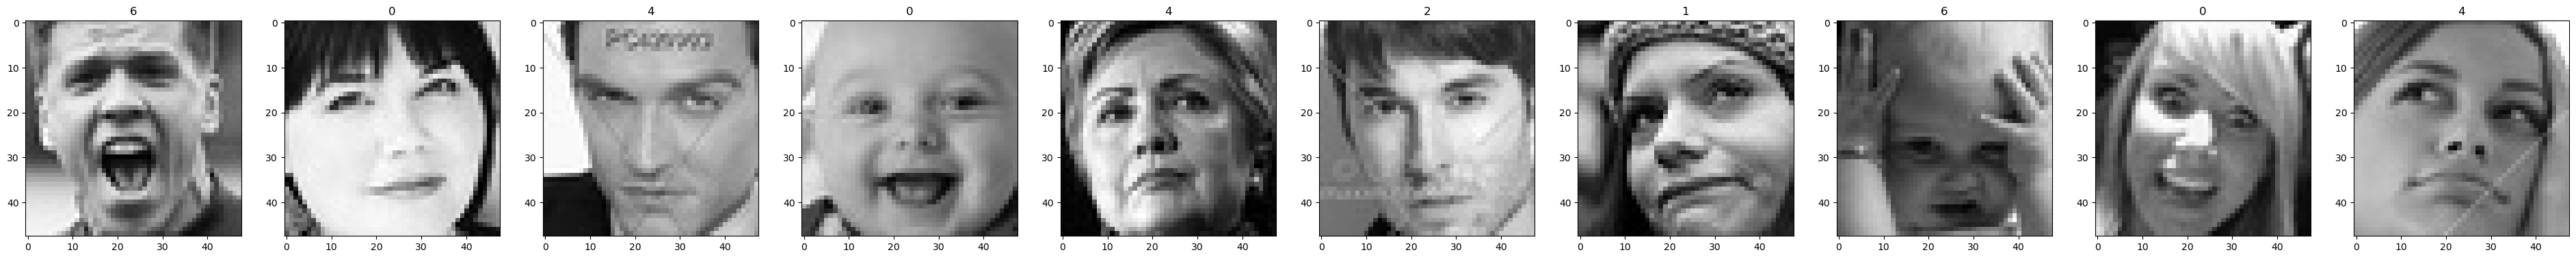

In [21]:
fig, axs = plt.subplots(1,10, figsize=(48, 48))

for i in range(10):
    axs[i].imshow(X_train_filtered[i], cmap="gray")
    axs[i].set_title(y_train_filtered[i])

In [22]:
labels = {
    "happy": 0,
    "sad": 1,
    "neutral": 2,
    "surprise": 3,
    "angry": 4,
    "disgust": 5,
    "fear": 6
    }

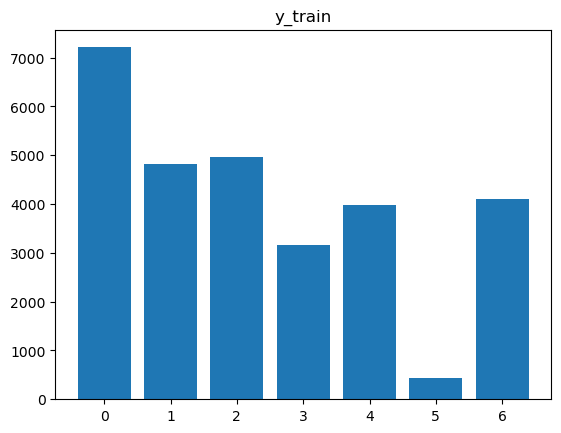

In [23]:
import matplotlib.pyplot as plt

def plot_values(data, title):
    values, counts = np.unique(data, return_counts=True)
    plt.bar(values, counts)
    plt.title(title)
    plt.show()

plot_values(y_train_filtered, "y_train")

In [24]:
X_train_scaled = X_train_filtered / 255.0
X_test_scaled = X_test_filtered / 255.0

In [25]:
# one-hot encoding
y_train_ohe = tf.one_hot(y_train_filtered, depth=7)
y_test_ohe = tf.one_hot(y_test_filtered, depth=7)

2024-04-28 17:50:45.828709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-28 17:50:45.829004: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-28 17:50:45.829011: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-28 17:50:45.829034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 17:50:45.829184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [27]:
import keras
from keras import layers

reg = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)

cnn_model = keras.Sequential([
    layers.Conv2D(64, (5,5), (1,1), activation = "relu", input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2], 1), padding = "same", kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation = "relu", kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5120, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(1024, activation="relu", kernel_regularizer=reg),
    layers.Dense(512, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=reg),
    layers.Dense(64, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax"),
])


cnn_model.summary()

/opt/miniconda3/envs/env2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5120)           │    39,654,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     5,243,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,536,583 (173.71 MB)

 Trainable params: 45,536,327 (173.71 MB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
loss = tf.keras.losses.CategoricalCrossentropy()

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=loss,
  metrics=["accuracy"])

In [29]:
cnn_model.fit(X_train_scaled, y_train_ohe, epochs=10, validation_split=0.2, shuffle=True, batch_size=64)

Epoch 1/10


2024-04-28 17:50:54.380802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.2769 - loss: 7.9567 - val_accuracy: 0.3252 - val_loss: 7.4685
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.4032 - loss: 7.1101 - val_accuracy: 0.4594 - val_loss: 6.5119
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.4704 - loss: 6.3002 - val_accuracy: 0.4854 - val_loss: 5.7961
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.5317 - loss: 5.5219 - val_accuracy: 0.4941 - val_loss: 5.1810
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.6035 - loss: 4.8132 - val_accuracy: 0.5274 - val_loss: 4.6990
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.7013 - loss: 4.1802 - val_accuracy: 0.4946 - val_loss: 4.5185
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.7978 - loss: 3.6444 - val_accuracy: 0.5411 - val_loss: 4.3280
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.8915 - loss: 3.1957 - val_accura

In [30]:
cnn_model.evaluate(X_test_scaled, y_test_ohe)

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5437 - loss: 4.3973


[4.373896598815918, 0.543235719203949]

In [31]:
cnn_model.save_weights("em1/feri_cnn_checkpoint.weights.h5")